In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt


def load_series(filename, series_idx=1):
    try:
        with open(filename) as csvfile:
            csvreader = csv.reader(csvfile)
            data = [float(row[series_idx]) for row in csvreader if len(row) > 0]
            normalized_data = (data - np.mean(data)) / np.std(data)
        return normalized_data
    except IOError:
        return None


def split_data(data, percent_train=0.80):
    num_rows = len(data)
    train_data, test_data = [], []
    for idx, row in enumerate(data):
        if idx < num_rows * percent_train:
            train_data.append(row)
        else:
            test_data.append(row)
    return train_data, test_data

(1008,)


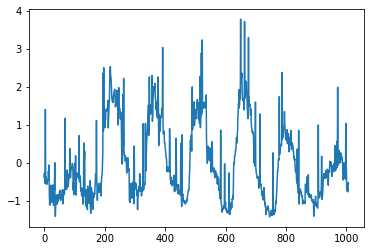

In [2]:
timeseries = load_series('week.csv')
print(np.shape(timeseries))

plt.figure()
plt.plot(timeseries)
plt.show()

In [3]:
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.python.ops import rnn, rnn_cell
import data_loader
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
class SeriesPredictor:

    def __init__(self, input_dim, seq_size, hidden_dim):
        # Hyperparameters
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim

        # Weight variables and input placeholders
        self.W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        self.y = tf.placeholder(tf.float32, [None, seq_size])

        # Cost optimizer
        self.cost = tf.reduce_mean(tf.square(self.model() - self.y))
        self.train_op = tf.train.AdamOptimizer(learning_rate=0.003).minimize(self.cost)

        # Auxiliary ops
        self.saver = tf.train.Saver()

    def model(self):
        """
        :param x: inputs of size [T, batch_size, input_size]
        :param W: matrix of fully-connected output layer weights
        :param b: vector of fully-connected output layer biases
        """
        cell = rnn_cell.BasicLSTMCell(self.hidden_dim)
        outputs, states = rnn.dynamic_rnn(cell, self.x, dtype=tf.float32)
        num_examples = tf.shape(self.x)[0]
        W_repeated = tf.tile(tf.expand_dims(self.W_out, 0), [num_examples, 1, 1])
        #out = tf.batch_matmul(outputs, W_repeated) + self.b_out
        out = tf.matmul(outputs, W_repeated) + self.b_out
        out = tf.squeeze(out)
        return out

    def train(self, train_x, train_y, test_x, test_y):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.initialize_all_variables())
            max_patience = 3
            patience = max_patience
            min_test_err = float('inf')
            step = 0
            while patience > 0:
                _, train_err = sess.run([self.train_op, self.cost], feed_dict={self.x: train_x, self.y: train_y})
                if step % 100 == 0:
                    test_err = sess.run(self.cost, feed_dict={self.x: test_x, self.y: test_y})
                    print('step: {}\t\ttrain err: {}\t\ttest err: {}'.format(step, train_err, test_err))
                    if test_err < min_test_err:
                        min_test_err = test_err
                        patience = max_patience
                    else:
                        patience -= 1
                step += 1
            save_path = self.saver.save(sess, 'model.ckpt')
            print('Model saved to {}'.format(save_path))

    def test(self, sess, test_x):
        tf.get_variable_scope().reuse_variables()
        self.saver.restore(sess, 'model.ckpt')
        output = sess.run(self.model(), feed_dict={self.x: test_x})
        return output

In [5]:
def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    plt.show()

In [6]:
seq_size = 5
predictor = SeriesPredictor(input_dim=1, seq_size=seq_size, hidden_dim=5)
data = data_loader.load_series('week.csv')
train_data, actual_vals = data_loader.split_data(data)


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


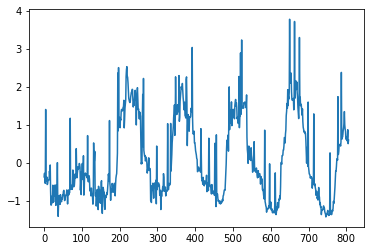

In [7]:
plt.plot(train_data)

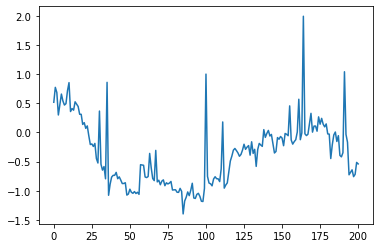

In [8]:
plt.plot(actual_vals)

In [9]:
train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])

In [10]:
import itertools

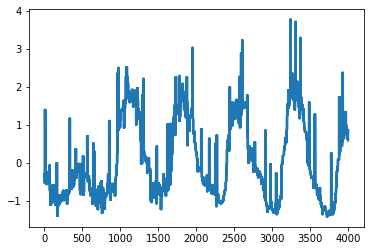

In [11]:
plt.plot(list(itertools.chain.from_iterable(train_x)))

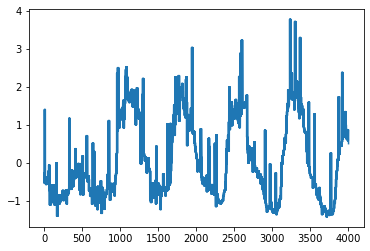

In [12]:
plt.plot(list(itertools.chain.from_iterable(train_y)))

In [13]:
test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])

predictor.train(train_x, train_y, test_x, test_y)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
step: 0		train err: 4.412376880645752		test err: 2.058143138885498
step: 100		train err: 0.6800839304924011		test err: 0.3973647654056549
step: 200		train err: 0.4175446033477783		test err: 0.2632077932357788
step: 300		train err: 0.2925352454185486		test err: 0.20134375989437103
step: 400		train err: 0.2431914359331131		test err: 0.17431478202342987
step: 500		train err: 0.22338634729385376		test err: 0.161127507686615
step: 600		train err: 0.21337756514549255		test err: 0.15398761630058289
step: 700		train err: 0.20709733664989471		test err: 0.1495179384946823
step: 800		train err: 0.20200105011463165		test err: 0.14567533135414124
step: 900		train err: 0.19737012684345245		test err: 0.1417626142501831
step: 1000		train err: 0.19356267154216766		test err: 0.13839305937290192
step: 1100		train err: 0.19079849123954773		test err: 0.13605044782161713
step: 1200		train err: 0.18868093192577362		test err: 0.13418616

INFO:tensorflow:Restoring parameters from model.ckpt
predicted_vals (195,)


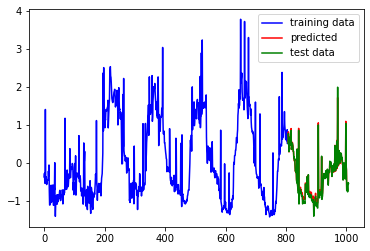

INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt


C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
INFO:tensorflow:Restoring parameters from model.ckpt
print results


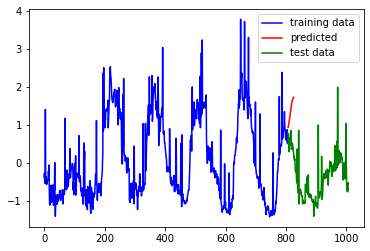

In [14]:
with tf.Session() as sess:
    predicted_vals = predictor.test(sess, test_x)[:,0]
    print('predicted_vals', np.shape(predicted_vals))
    plot_results(train_data, predicted_vals, actual_vals, 'predictions.png')

    prev_seq = train_x[-1]
    predicted_vals = []
    for i in range(20):
        next_seq = predictor.test(sess, [prev_seq])
        predicted_vals.append(next_seq[-1])
        prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))
            
    print('print results')
    plot_results(train_data, predicted_vals, actual_vals, 'hallucinations.png')
